### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchinfo
import torchvision
from torch import nn

from config import *
from data import *
from models import *
from utils import *
import pandas as pd
from umap import UMAP

plt.rcParams["font.family"] = "STIXGeneral"

In [2]:
cfg = get_defaults()
cfg = get_cfg(
    "dae_vit_small", "imagenette", "config/model_cfg.yaml", "config/data_cfg.yaml", cfg
)

cfg.batch_size = 4
# cfg.patch_size = 16
cfg.pretrained = True

yaml_cfg = cfg.to_yaml()

print(colored(f"Config:", "green", attrs=["bold"]))
print(colored(yaml_cfg))

Config:
batch_size: 4
data_dir: /home/zonularity/aecc/data
dataset: imagenette
decoder_head: 8
decoder_layer: 8
emb_dim: 192
encoder_head: 6
encoder_layer: 12
img_size: 128
in_channels: 3
log_dir: /home/zonularity/aecc/logs
lr: 0.0005
model_dir: /home/zonularity/aecc/weights
model_name: dae_vit_small
momentum: 0.9
noise_factor: 0.25
normalize: default
num_epochs: 100
num_workers: 4
patch_size: 8
pin_memory: true
pretrained: true
root_dir: /home/zonularity/aecc
seed: 42
val_freq: 10
val_size: 0.1
weight_decay: 0.005



### Visualizing Data

In [3]:
train_dataloader, val_dataloader, test_dataloader, steps_per_epoch = load_dataset(cfg)

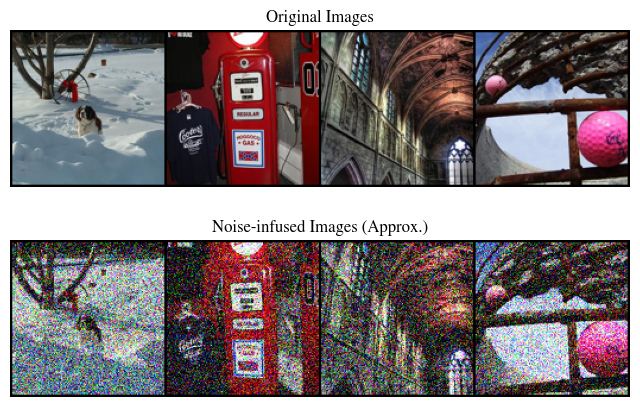

In [4]:
# Visualize some test images
dataiter = next(iter(train_dataloader))
noisy, original = dataiter

# show images
plt.figure(figsize=(8, 5))
plt.subplot(2, 1, 1)
plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(original[:8], padding=2, nrow=4), (1, 2, 0)
    )
)
plt.axis("off")
plt.title("Original Images")
plt.subplot(2, 1, 2)
plt.imshow(
    np.transpose(torchvision.utils.make_grid(noisy[:8], padding=2, nrow=4), (1, 2, 0))
)
plt.title("Noise-infused Images (Approx.)")
plt.axis("off")
plt.show()

### Model & Methodology

In [5]:
# Initialize the autoencoder
model = DAEViT(
    in_channels=cfg.in_channels,
    img_size=cfg.img_size,
    patch_size=cfg.patch_size,
    emb_dim=cfg.emb_dim,
    encoder_layer=cfg.encoder_layer,
    encoder_head=cfg.encoder_head,
    decoder_layer=cfg.decoder_layer,
    decoder_head=cfg.decoder_head,
    gate=nn.Sigmoid,
)

if cfg.pretrained:
    state_dict = torch.load(f"weights/{cfg.model_name}_{cfg.dataset}.ckpt")[
        "state_dict"
    ]
    state_dict = {k.replace("model.", ""): v for k, v in state_dict.items()}
    model.load_state_dict(state_dict)

torchinfo.summary(
    model, input_size=(1, cfg.in_channels, cfg.img_size, cfg.img_size), depth=2
)

Layer (type:depth-idx)                        Output Shape              Param #
DAEViT                                        [1, 3, 128, 128]          --
├─ViTEncoder: 1-1                             [257, 1, 192]             49,344
│    └─Conv2d: 2-1                            [1, 192, 16, 16]          37,056
│    └─Sequential: 2-2                        [1, 257, 192]             5,331,456
│    └─LayerNorm: 2-3                         [1, 257, 192]             384
├─RayleighChannel: 1-2                        [257, 1, 192]             --
├─ViTDecoder: 1-3                             [1, 3, 128, 128]          49,344
│    └─Sequential: 2-4                        [1, 257, 192]             3,554,304
│    └─Linear: 2-5                            [256, 1, 192]             37,056
│    └─Rearrange: 2-6                         [1, 3, 128, 128]          --
│    └─Sigmoid: 2-7                           [1, 3, 128, 128]          --
Total params: 9,058,944
Trainable params: 9,058,944
Non-trainabl

Encoder

In [6]:
# Encoder
encoder = model.encoder

# Encode a batch of images
encoded = encoder(original.to("cuda"))

print(colored("Input shape:", "green"), original.shape)
print(colored("Encoded shape:", "green"), encoded.shape)

Input shape: torch.Size([4, 3, 128, 128])
Encoded shape: torch.Size([257, 4, 192])


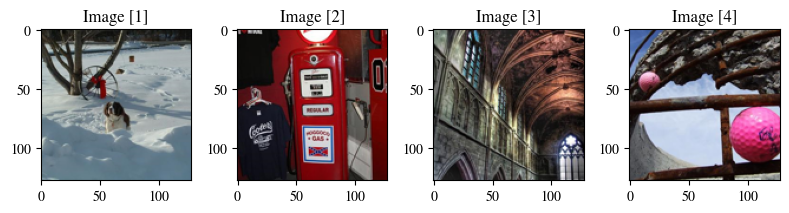

<Figure size 640x480 with 0 Axes>

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(8, 5))

# Loop over the first 4 original images
for i in range(4):
    axs[i].imshow(
        original.permute(0, 2, 3, 1)[i].cpu().detach().numpy(),
    )
    axs[i].set_title(f"Image [{i+1}]")

plt.tight_layout()
plt.savefig("report/figs/batch.pdf", bbox_inches="tight", dpi=300)
plt.show()

plt.tight_layout()
plt.show()

Channel

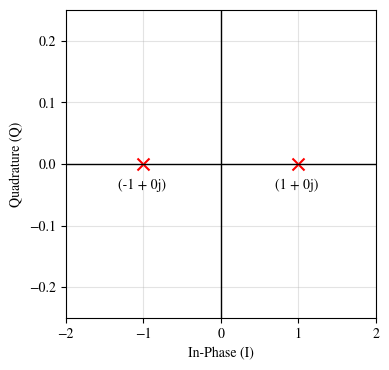

In [8]:
# Instantiate transmission modules
transmitter = BPSKTransmitter()
ieee754_single = IEEE754(precision="single")

# Visualize transmission (through constellations)
bin_rep = ieee754_single.float_to_binary(  # binary representation
    encoded.permute(1, 0, 2).cpu().detach().numpy()
)
bin_arr = transmitter.to_arr(bin_rep)  # str to array
mod_arr = transmitter.modulate(bin_arr)
unique_mod = np.unique(mod_arr)

# Plot constellation
plt.figure(figsize=(4, 4))
plt.scatter(
    unique_mod.real, unique_mod.imag, marker="x", color="red", s=75, label="Noiseless"
)
plt.xlabel("In-Phase (I)")
plt.ylabel("Quadrature (Q)")
plt.xlim(-2, 2)
plt.ylim(-0.25, 0.25)

# Highlight the origin axis
plt.axhline(0, color="black", linewidth=1)
plt.axvline(0, color="black", linewidth=1)

# Add text to points
plt.text(-0.7, -0.04, "(-1 + 0j)", ha="right")
plt.text(0.7, -0.04, "(1 + 0j)", ha="left")

plt.grid(alpha=0.35)
plt.savefig("report/figs/bpsk.pdf", bbox_inches="tight", dpi=300)
plt.show()

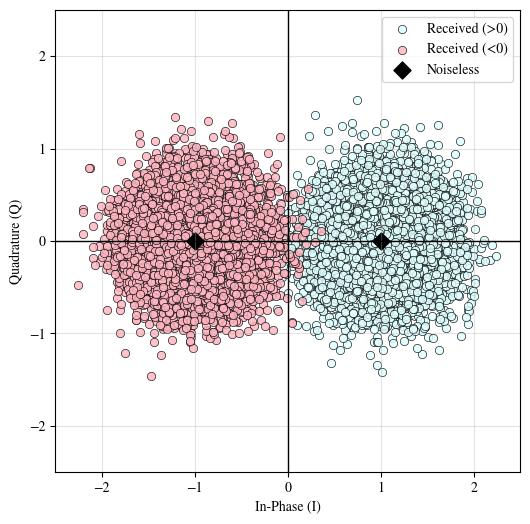

In [9]:
# Add complex noise to each point
def add_noise(x, noise):
    return x + (
        noise
        * (np.random.randn(*x.shape) + 1j * np.random.randn(*x.shape))
        / np.sqrt(2)
    )

fct = 0.5

# Split mod_arr into two arrays based on the condition
mod_arr_gt0 = mod_arr[mod_arr > 0]
mod_arr_lt0 = mod_arr[mod_arr < 0]

# Add noise to both arrays
noisy_mod_arr_gt0 = add_noise(mod_arr_gt0, fct)
noisy_mod_arr_lt0 = add_noise(mod_arr_lt0, fct)

# Plot constellation
plt.figure(figsize=(6, 6))

# Plot the array with values > 0 with color green
plt.scatter(
    noisy_mod_arr_gt0.flatten()[:10000].real,
    noisy_mod_arr_gt0.flatten()[:10000].imag,
    marker="o",
    edgecolor="black",
    linewidth=0.5,
    alpha=0.85,
    color="lightcyan",
    label="Received (>0)",
)

# Plot the array with values < 0 with color blue
plt.scatter(
    noisy_mod_arr_lt0.flatten()[:10000].real,
    noisy_mod_arr_lt0.flatten()[:10000].imag,
    marker="o",
    edgecolor="black",
    linewidth=0.5,
    alpha=0.85,
    color="lightpink",
    label="Received (<0)",
)
plt.scatter(
    unique_mod.real, unique_mod.imag, marker="D", color="k", s=75, label="Noiseless"
)
plt.xlabel("In-Phase (I)")
plt.ylabel("Quadrature (Q)")
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)

# Highlight the origin axis
plt.axhline(0, color="black", linewidth=1)
plt.axvline(0, color="black", linewidth=1)

plt.grid(alpha=0.35)
plt.legend()
plt.savefig("report/figs/received_bpsk.pdf", bbox_inches="tight", dpi=300)
plt.show()

In [10]:
# Add rayleigh noise to the encoded images
rayleigh = RayleighChannel(cfg.noise_factor)
encoded_noise = rayleigh(encoded)

print(colored("Encoded shape:", "green"), encoded.shape)
print(colored("Encoded with noise shape:", "green"), encoded_noise.shape)

Encoded shape: torch.Size([257, 4, 192])
Encoded with noise shape: torch.Size([257, 4, 192])


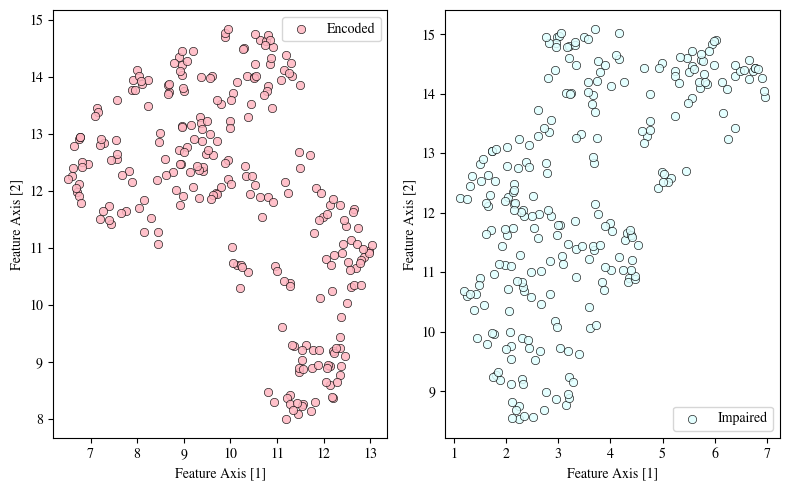

In [11]:
# Flatten the features
flattened_encoded = encoded.reshape(encoded.shape[0], -1).cpu().detach().numpy()
flattened_encoded_noise = (
    encoded_noise.reshape(encoded_noise.shape[0], -1).cpu().detach().numpy()
)

# Apply UMAP
umap = UMAP()
umap_encoded = umap.fit_transform(flattened_encoded)
umap_encoded_noise = umap.fit_transform(flattened_encoded_noise)

# Visualize UMAP encoded features
fig, axs = plt.subplots(1, 2, figsize=(8, 5))

axs[0].scatter(
    umap_encoded[:, 0],
    umap_encoded[:, 1],
    marker="o",
    edgecolor="black",
    linewidth=0.5,
    alpha=0.85,
    color="lightpink",
    label="Encoded",
)
axs[0].set_xlabel("Feature Axis [1]")
axs[0].set_ylabel("Feature Axis [2]")
axs[0].legend()

axs[1].scatter(
    umap_encoded_noise[:, 0],
    umap_encoded_noise[:, 1],
    marker="o",
    edgecolor="black",
    linewidth=0.5,
    alpha=0.85,
    color="lightcyan",
    label="Impaired",
)

axs[1].set_xlabel("Feature Axis [1]")
axs[1].set_ylabel("Feature Axis [2]")
axs[1].legend()

plt.tight_layout()
plt.savefig("report/figs/umap.pdf", bbox_inches="tight", dpi=300)
plt.show()

Decoder

In [12]:
# Decoder
decoder = model.decoder

# Decode a batch of features
decoded = decoder(encoded_noise.to("cuda"))

print(colored("Input shape:", "yellow"), encoded_noise.shape)
print(colored("Decoded image:", "yellow"), decoded.shape)

Input shape: torch.Size([257, 4, 192])
Decoded image: torch.Size([4, 3, 128, 128])


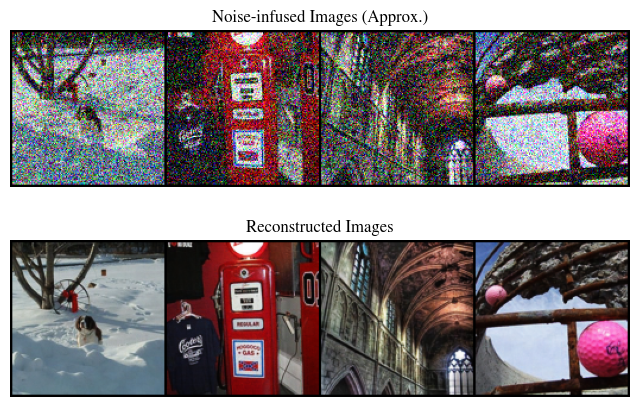

In [13]:
# show images
plt.figure(figsize=(8, 5))
plt.subplot(2, 1, 1)
plt.imshow(
    np.transpose(torchvision.utils.make_grid(noisy[:8], padding=2, nrow=4), (1, 2, 0))
)
plt.axis("off")
plt.title("Noise-infused Images (Approx.)")
plt.subplot(2, 1, 2)
plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(decoded[:8], padding=2, nrow=4).cpu(), (1, 2, 0)
    )
)
plt.title("Reconstructed Images")
plt.axis("off")
plt.savefig("report/figs/comparison.pdf", bbox_inches="tight", dpi=300)
plt.show()

### Results

Train and Validation Loss

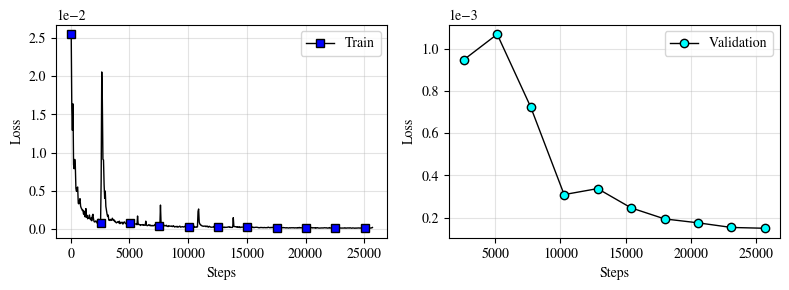

In [14]:
train_df = pd.read_csv("resources/train.csv")
val_df = pd.read_csv("resources/val.csv")

train_x = train_df["Step"]
train_y = train_df["Value"]
val_x = val_df["Step"]
val_y = val_df["Value"]

fig, axs = plt.subplots(1, 2, figsize=(8, 3))  # 1 row, 2 columns

# Plot for training data
axs[0].plot(
    train_x,
    train_y,
    marker="s",
    markerfacecolor="blue",
    markeredgecolor="k",
    color="k",
    linewidth=1,
    label="Train",
    markevery=50,
)
axs[0].set_xlabel("Steps")
axs[0].set_ylabel("Loss")
axs[0].ticklabel_format(
    style="sci", axis="y", scilimits=(0, 0)
)  # Change to scientific notation
axs[0].grid(alpha=0.35)
axs[0].legend()

# Plot for validation data
axs[1].plot(
    val_x,
    val_y,
    marker="o",
    markerfacecolor="cyan",
    markeredgecolor="k",
    color="k",
    linewidth=1,
    label="Validation",
)
axs[1].set_xlabel("Steps")
axs[1].set_ylabel("Loss")
axs[1].ticklabel_format(
    style="sci", axis="y", scilimits=(0, 0)
)  # Change to scientific notation
axs[1].grid(alpha=0.35)
axs[1].legend()

plt.tight_layout()
plt.savefig("report/figs/loss.pdf", bbox_inches="tight", dpi=300)
plt.show()

Structural Similarity Index (SSIM)

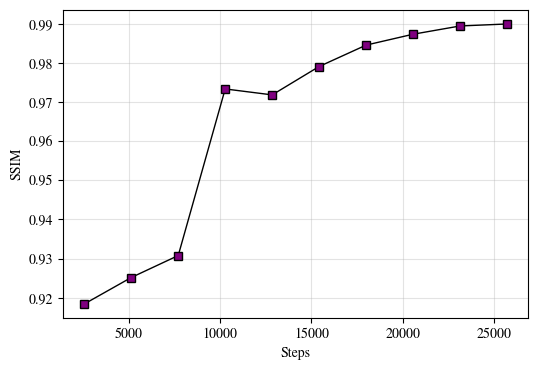

In [15]:
df = pd.read_csv("resources/ssim.csv")
x = df["Step"]
y = df["Value"]

plt.figure(figsize=(6, 4))
plt.plot(
    x,
    y,
    marker="s",
    markerfacecolor="purple",
    markeredgecolor="k",
    color="k",
    linewidth=1,
)
plt.xlabel("Steps")
plt.ylabel("SSIM")
plt.grid(alpha=0.35)
plt.savefig("report/figs/ssim.pdf", bbox_inches="tight", dpi=300)
plt.show()

Peak Signal-to-Noise Ratio (PSNR)

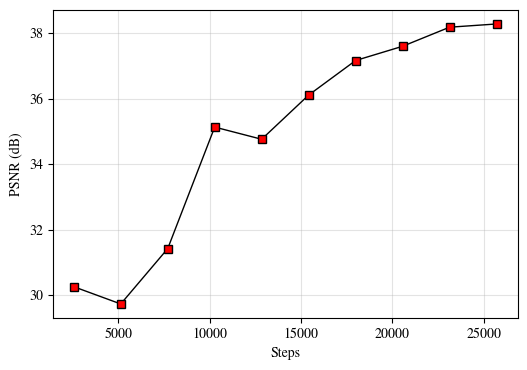

In [16]:
df = pd.read_csv("resources/psnr.csv")
x = df["Step"]
y = df["Value"]

plt.figure(figsize=(6, 4))
plt.plot(
    x,
    y,
    marker="s",
    markerfacecolor="red",
    markeredgecolor="k",
    color="k",
    linewidth=1,
)
plt.xlabel("Steps")
plt.ylabel("PSNR (dB)")
plt.grid(alpha=0.35)
plt.savefig("report/figs/psnr.pdf", bbox_inches="tight", dpi=300)
plt.show()